In [14]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import copy
import random
import time 
import plotly.express as px
import seaborn as sns
from copy import deepcopy
sys.path.insert(1, '/workspaces/baseline')
from pointcept.datasets.osdar23 import OSDaR23Dataset

from pointcept.datasets.transform import Sparsify
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

Learning/color map definition

In [3]:
annotation_disregarded = -2
learning_map = {
            'background':         0,
            'person':             1,
            'crowd':              1,
            'train':              2,
            'wagons':             2,
            'bicycle':            0,
            'group_of_bicycles':  0,
            'motorcycle':         0,
            'road_vehicle':       3,
            'animal':             0,
            'group_of_animals':   0,
            'wheelchair':         0,
            'drag_shoe':          0,
            'track':              4,
            'transition':         4,
            'switch':             annotation_disregarded,
            'catenary_pole':      5,
            'signal_pole':        6,
            'signal':             6,
            'signal_bridge':      0,
            'buffer_stop':        7,
            'flame':              0,
            'smoke':              0
        }

learning_map_inv = {
            #ignore_index: ignore_index,  # "unlabeled"
            0 : 'background',
            1 : 'person',
            2 : 'train' ,       
            3 : 'road_vehicle',
            4 : 'track',
            5 : 'catenary_pole',
            6 : 'signal',
            7 : 'buffer_stop',
        }

color_map = {#ignore_index:[211, 211, 211],
            0:[211, 211, 211],
            1: [255, 0, 0],  # Person -> Red
            2: [255, 215, 0],# Train -> Yellow
            3: [0, 139, 139],# Road vehicle -> Dark blue
            4: [255, 0, 255],# Track -> Pink
            5: [255, 140, 0],# Catenary_pole -> Orange
            6: [0, 191, 255],# Signal -> Flash blue
            7: [186, 85, 211],# Buffer stop -> Purple
            }

[2024-09-03 11:58:37,100 INFO defaults.py line 58 1133] Totally 1048 x 1 samples in train set.


Scene/frame: 3.1 58


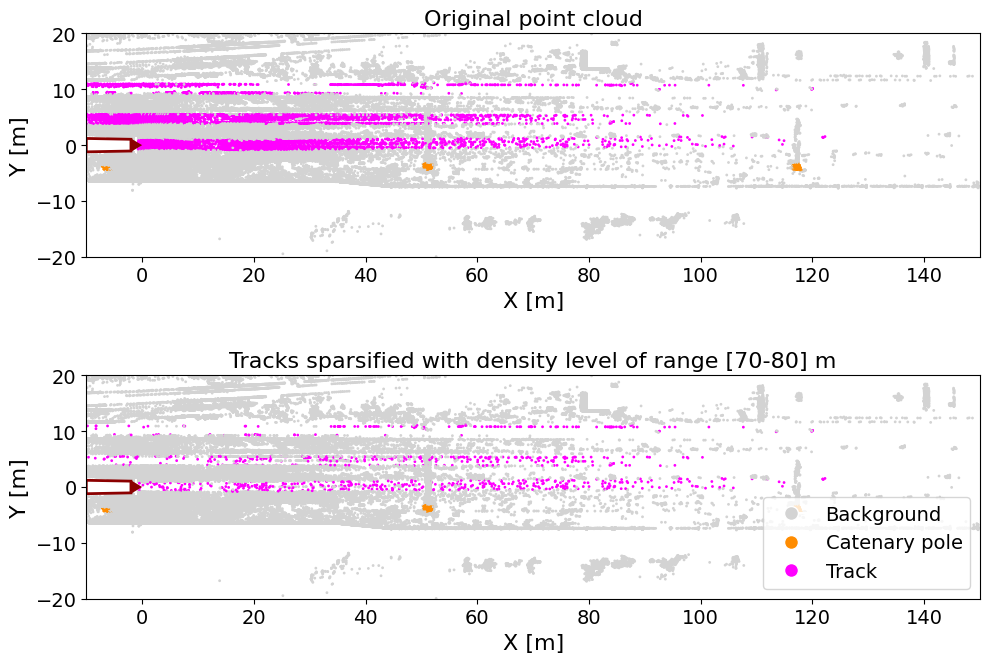

In [102]:
# ----------- Start of the code ------------
random.seed(32) # Good seed (and the one I made the exemple with): 32

data = OSDaR23Dataset(data_root="/workspaces/baseline/exp/preprocessed_pcd", learning_map=learning_map,csv_person_presence_path="/workspaces/baseline/railseg/csv_stats/person_frames.csv")

data_dict = data.get_data(158) # was 140 before

original_dict = deepcopy(data_dict)

# ----- Sparsifying of track ----------
end_range=80
transform = Sparsify(end_range, track_label=4, p=1)
data_dict = transform(data_dict)

# --- generate 2D plots for sprase track ---
print("Scene/frame:",data_dict["scene"], data_dict["frame"])

# Assuming original_dict and data_dict, color_map, and end_range are defined

# Extract data for the first plot
x1 = original_dict["coord"][:, 0]
y1 = original_dict["coord"][:, 1]
c1 = [np.array(color_map[segmentation]) / 255 for segmentation in original_dict["segment"]]

# Extract data for the second plot
x2 = data_dict["coord"][:, 0]
y2 = data_dict["coord"][:, 1]
c2 = [np.array(color_map[segmentation]) / 255 for segmentation in data_dict["segment"]]

# Create a figure with two subplots (one on top of the other)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [1, 1]})

# Plot the first set of data on the first axis
scatter1 = ax1.scatter(x1, y1, c=c1, s=1)
ax1.set_xlim(-10, 150)
ax1.set_ylim(-20, 20)
ax1.set_aspect('equal')
ax1.set_title("Original point cloud", fontsize=16)
ax1.set_xlabel('X [m]', fontsize=16)
ax1.set_ylabel('Y [m]', fontsize=16)

# Plot the second set of data on the second axis
scatter2 = ax2.scatter(x2, y2, c=c2, s=1)
ax2.set_xlim(-10, 150)
ax2.set_ylim(-20, 20)
ax2.set_aspect('equal')
ax2.set_title(f"Tracks sparsified with density level of range [{end_range-10}-{end_range}] m", fontsize=16)
ax2.set_xlabel('X [m]', fontsize=16)
ax2.set_ylabel('Y [m]', fontsize=16)

# Set tick size for both axes
ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)

# Create legend with circle markers
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array([211, 211, 211]) / 255, markersize=10, label='Background'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array([255, 140, 0]) / 255, markersize=10, label='Catenary pole'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array([255, 0, 255]) / 255, markersize=10, label='Track')
]

# circle1 = plt.Circle((0, 0), 70, edgecolor='dimgray', facecolor="none")
# circle2 = plt.Circle((0, 0), 80, edgecolor='dimgray', facecolor="none")
# ax2.add_patch(circle1)
# ax2.add_patch(circle2)


# Add the legend to the first subplot in the upper left corner
ax2.legend(handles=legend_elements, loc='lower right', fontsize=14)


# Add shape
rectangle_point =np.array([[-2,-1.05],[-2,1.05],[-10,1.2],[-10,-1.2]])
locomotive1 = plt.Polygon(rectangle_point, facecolor="white", edgecolor="darkred",lw=2)
locomotive2 = plt.Polygon(rectangle_point, facecolor="white", edgecolor="darkred",lw=2)
ax1.add_patch(locomotive1)
ax2.add_patch(locomotive2)

triangle_point =np.array([[-2,-1.2],[-2,1.2],[0,0]])
t1 = plt.Polygon(triangle_point, facecolor="darkred", edgecolor="none",lw=0)
t2 = plt.Polygon(triangle_point, color="darkred",lw=0)
ax1.add_patch(t1)
ax2.add_patch(t2)


# Adjust layout to reduce space between plots and around the figure
fig.tight_layout()#(pad=1, h_pad=-1, w_pad=0.1)

#  UNCOMMENT TO Save the figure
# fig.savefig("/workspaces/baseline/exp/figures/report_figs/sparser_tracks_example.jpeg", dpi=400,bbox_inches="tight")
# plt.close(fig)


In [114]:
np.unique([original_dict["instance"]])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

[2024-09-03 14:23:45,644 INFO defaults.py line 58 1133] Totally 1048 x 1 samples in train set.


Scene/frame: 3.1 58


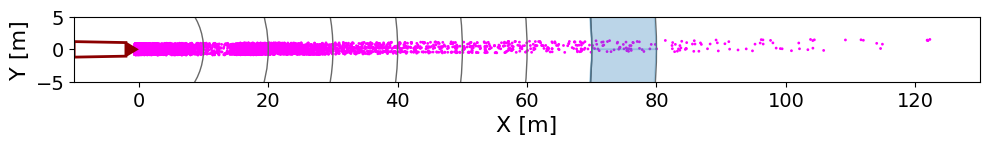

In [154]:
def add_circle(r, ax):
    circle1 = plt.Circle((0, 0), r, edgecolor='dimgray', facecolor="none")
    ax1.add_patch(circle1)


# ----------- Start of the code ------------
random.seed(32) # Good seed (and the one I made the exemple with): 32

data = OSDaR23Dataset(data_root="/workspaces/baseline/exp/preprocessed_pcd", learning_map=learning_map,csv_person_presence_path="/workspaces/baseline/railseg/csv_stats/person_frames.csv")

data_dict = data.get_data(158) # was 140 before

original_dict = deepcopy(data_dict)

# ----- Sparsifying of track ----------
end_range=80
transform = Sparsify(end_range, track_label=4, p=1)
data_dict = transform(data_dict)

# --- generate 2D plots for sprase track ---
print("Scene/frame:",data_dict["scene"], data_dict["frame"])

# Assuming original_dict and data_dict, color_map, and end_range are defined
mask = np.where(original_dict["instance"]==9)
# Extract data for the first plot
x1 = original_dict["coord"][mask, 0]
y1 = original_dict["coord"][mask, 1]
c1 = [np.array(color_map[segmentation]) / 255 for segmentation in original_dict["segment"][mask]]


# Create a figure with two subplots (one on top of the other)
fig, ax1 = plt.subplots(1, 1, figsize=(10, 7))#, gridspec_kw={'height_ratios': [1, 1]})

# Plot the first set of data on the first axis
scatter1 = ax1.scatter(x1, y1, c=c1, s=1)
ax1.set_xlim(-10, 130)
ax1.set_ylim(-5, 5)
ax1.set_aspect('equal')
ax1.set_xlabel('X [m]', fontsize=16)
ax1.set_ylabel('Y [m]', fontsize=16)

for r in range(10,80,10):
    add_circle(r, ax1)

# Set tick size for both axes
ax1.tick_params(axis='both', which='major', labelsize=14)


circle1 = plt.Circle((0, 0), 70, edgecolor='dimgray', facecolor="none")
circle2 = plt.Circle((0, 0), 80, edgecolor='dimgray', facecolor="none")
ax1.add_patch(circle1)
ax1.add_patch(circle2)



n, radii = 50, [70, 80]
theta = np.linspace(0, 2*np.pi, n, endpoint=True)
xs = np.outer(radii, np.cos(theta))
ys = np.outer(radii, np.sin(theta))

# in order to have a closed area, the circles
# should be traversed in opposite directions
xs[1,:] = xs[1,::-1]
ys[1,:] = ys[1,::-1]


ax1.fill(np.ravel(xs), np.ravel(ys), edgecolor='#348ABD',alpha=0.3)

# Add the legend to the first subplot in the upper left corner
#ax1.legend(handles=legend_elements, loc='lower right', fontsize=14)

white_box_pts =np.array([[-2,-10],[-2,10],[-10,10],[-10,-10]])
white_box = plt.Polygon(white_box_pts , facecolor="white", edgecolor="none",lw=2)
white_box  = plt.Polygon(white_box_pts , facecolor="white", edgecolor="none",lw=2)
ax1.add_patch(white_box)

# Add shape
rectangle_point =np.array([[-2,-1.05],[-2,1.05],[-10,1.2],[-10,-1.2]])
locomotive1 = plt.Polygon(rectangle_point, facecolor="white", edgecolor="darkred",lw=2)
locomotive2 = plt.Polygon(rectangle_point, facecolor="white", edgecolor="darkred",lw=2)
ax1.add_patch(locomotive1)


triangle_point =np.array([[-2,-1.2],[-2,1.2],[0,0]])
t1 = plt.Polygon(triangle_point, facecolor="darkred", edgecolor="none",lw=0)
t2 = plt.Polygon(triangle_point, color="darkred",lw=0)
ax1.add_patch(t1)




# Adjust layout to reduce space between plots and around the figure
fig.tight_layout()#(pad=1, h_pad=-1, w_pad=0.1)

#  UNCOMMENT TO Save the figure
# fig.savefig("/workspaces/baseline/exp/figures/report_figs/sparsification_explained.jpeg", dpi=400,bbox_inches="tight")
# plt.close(fig)


### To create the plot of track error map : (expend)
run predict_sem_seg.py with this copy pasted in inference_cfg.yml (if you see a small difference with the plots that I had showed during the second presentation to Jan, it is because the way the "switch" object was aprehended changed in between ( go read weekly meeting from 17.06))

weight_path: /workspaces/baseline/exp/milestone_runs/22_05_2024/model/model_best.pth
config_path: /workspaces/baseline/configs/osdar23/DEBUG_OSDaR23.py
data_path: /workspaces/baseline/data/OSDaR_dataset/v_2

normalize_intensity: False

run_all_val_set: True # If True, will run inference on each frame of the validation set. Else, it only runs on frame specifically defined in "evaluated_frames"
val_set: ["2_station_berliner_tor_2.1","3_fire_site_3.4","4_station_pedestrian_bridge_4.2","4_station_pedestrian_bridge_4.5","6_station_klein_flottbek_6.1","7_approach_underground_station_7.2","9_station_ruebenkamp_9.3","9_station_ruebenkamp_9.4","9_station_ruebenkamp_9.5","9_station_ruebenkamp_9.7","11_main_station_11.1","14_signals_station_14.2","14_signals_station_14.3","18_vegetation_switch_18.1","21_station_wedel_21.3"]

use_preprocessed: False

export_las_file: False # If set to true, will export the infered pcd under "out_path"

# General directory for where exported file will be stored.
out_path: "/workspaces/baseline/exp/temporary_export/plot_adjustement" #"/workspaces/baseline/exp"

save_error_map: True
save_confusion_matrix: False
save_pose_stat: True
export_projected_pcd: False
save_stat_metric: False

# Meant to be used only once, to create the GT map of semantic point location in training split
save_gt_map: False


### Creation of plot for precise results WandB

In [15]:
# df=pd.read_csv("/workspaces/baseline/exp/data_for_plot_creation/wandb_PRECISE_results_ONline_sparse_70-80m_more_columns.csv") # Value from https://wandb.ai/nmuenger/RESULTS_Precise_test_sparse_80m?nw=nwusernmuenger
df=pd.read_csv("/workspaces/baseline/exp/data_for_plot_creation/wandb_UNPRECISE_ONline_sparse_70-80m.csv") # Values from https://wandb.ai/nmuenger/training_sparsify_70-80m?nw=nwusernmuenger
display(df.head(1))
df = df.iloc[:,1:] # Remove useless column with name of single experiment
#df = df.set_axis(['Augmentation value', '0-20m rIoU', '20-40m rIoU', '40-60m rIoU', '60-80m rIoU', '80-100m rIoU', '100-140m rIoU', '140-180m rIoU', 'Complete IoU', 'mIoU on all classes<br>& ranges'], axis=1) # Rename columns with desired names
df = df.set_axis(['Augmentation value', '0-20m rIoU', '20-40m rIoU', '40-60m rIoU', '60-80m rIoU', '80-100m rIoU', 'Complete IoU', 'mIoU on all classes<br>& ranges'], axis=1) # Rename columns with desired names
print("After modification of the column names:")
display(df.head(1))

Name  prob_augmentation_sparse  per_class/iou/0-20/track  \
0  Online sparse aug. 0.8                       0.8                  0.858257   

   per_class/iou/20-40/track  per_class/iou/40-60/track  \
0                    0.81109                   0.651519   

   per_class/iou/60-80/track  per_class/iou/80-100/track  \
0                   0.439979                    0.130617   

   per_class/iou/total/track  val/total/mIoU  
0                   0.818079        0.754495

After modification of the column names:


Augmentation value  0-20m rIoU  20-40m rIoU  40-60m rIoU  60-80m rIoU  \
0                 0.8    0.858257      0.81109     0.651519     0.439979   

   80-100m rIoU  Complete IoU  mIoU on all classes<br>& ranges  
0      0.130617      0.818079                         0.754495

In [16]:
#df = df.drop(columns=["100-140m rIoU", "140-180m rIoU", "mIoU on all classes<br>& ranges"])
df = df.drop(columns=["mIoU on all classes<br>& ranges"])
df["Mean rIoU 0-100m"] = df[['0-20m rIoU', '20-40m rIoU', '40-60m rIoU', '60-80m rIoU', '80-100m rIoU']].sum(axis=1)/5
# Create suitable plot for bar plot with plotly

melted_df = df.melt(id_vars=["Augmentation value"],
                        var_name="Range",
                        value_name="IoU")
melted_df = melted_df.sort_values(by=["Range","Augmentation value"]) # Sort values in a good way
melted_df["IoU"] = melted_df["IoU"]*100

In [17]:
values_with_no_augmentation = df[df["Augmentation value"]==0]

In [18]:
def return_fig_line_plot(melted_df, x_axis_title, plot_title, category_orders, y_axis_title="IoU"):
    fig = px.line(melted_df.sort_values("Augmentation value"),x="Augmentation value", y="IoU",color="Range", category_orders=category_orders,
                title=plot_title, markers=True)
    # fig = px.line(melted_df.sort_values("Augmentation value"),x="Augmentation value", y="IoU",color="Range",
    #             title=plot_title, markers=True)

    fig.update_traces(line=dict(dash="dot"),
            selector=dict(name="Mean rIoU 0-100m")) # Set "general" line as dotted
    fig.update_traces(line=dict(dash="dot"),
            selector=dict(name="Complete IoU")) # Set "general" line as dotted

    fig.update_traces(marker=dict(size=6,))
                
    fig.update_layout(
        title=dict(font=dict(size=20)),
        xaxis_title_font=dict(size=18),  # X-axis title font size
        yaxis_title_font=dict(size=18),  # Y-axis title font size
        xaxis=dict(tickfont=dict(size=16)),  # X-axis tick font size
        yaxis=dict(tickfont=dict(size=16)),  # Y-axis tick font size
        title_x=0.5
    )

    fig.update_layout(
        autosize=False,
        width=800,
        height=500,
        margin=dict(l=20, r=20, t=70, b=20),
        xaxis = dict(
                        tickmode='array', #change 1
                        tickvals = np.arange(0,1.1,0.1), #change 2
                        ticktext = np.round(np.arange(0,1.1,0.1),2), #change 3
                        ),
    )

    # Update the axes labels
    fig.update_xaxes(title_text=x_axis_title)
    fig.update_yaxes(title_text=y_axis_title)

    fig.update_xaxes(range = [0,1])
 
    return fig

In [19]:
fig = return_fig_line_plot(melted_df, "Prob. on the fly augmentation", 'IoUs for class track, given range to sensor. <br>On the fly augmentation procedure',
                           category_orders={"Range": ['0-20m rIoU', '20-40m rIoU', '40-60m rIoU', '60-80m rIoU', '80-100m rIoU', "Mean rIoU 0-100m", 'Complete IoU']})
fig.show()
#fig.write_image("/workspaces/baseline/exp/figures/report_figs/RAW_ONline_sparse_augmentation_70-80m_line_plot.jpeg", scale=4)

In [27]:
# FOR 70-80 m , bet p= 0.6
melted_df[melted_df["Augmentation value"]==0.6].round(2)#.max()

Augmentation value             Range    IoU
4                  0.6        0-20m rIoU  86.64
15                 0.6       20-40m rIoU  81.61
26                 0.6       40-60m rIoU  64.74
37                 0.6       60-80m rIoU  43.15
48                 0.6      80-100m rIoU  13.93
59                 0.6      Complete IoU  82.39
70                 0.6  Mean rIoU 0-100m  58.01

#### For ranges 40m-50m !

In [28]:
# PRECISE results
# df=pd.read_csv("/workspaces/baseline/exp/data_for_plot_creation/wandb_PRECISE_results_ONline_sparse_40-50m.csv")  https://wandb.ai/nmuenger/RESULTS_Precise_test_sparse_50m?nw=nwusernmuenger
# UNprecise results (during validation)
df=pd.read_csv("/workspaces/baseline/exp/data_for_plot_creation/wandb_UNPRECISE_ONline_sparse_40-50m.csv") # Values from https://wandb.ai/nmuenger/training_sparsify_40-50m?nw=nwusernmuenger

display(df.head(1))
df = df.iloc[:,1:] # Remove useless column with name of single experiment
df = df.set_axis(['Augmentation value', '0-20m rIoU', '20-40m rIoU', '40-60m rIoU', '60-80m rIoU', '80-100m rIoU', 'Complete IoU', 'mIoU on all classes<br>& ranges'], axis=1) # Rename columns with desired names
print("After modification of the column names:")
display(df.head(1))

Name  prob_augmentation_sparse  per_class/iou/0-20/track  \
0  Online sparse 50 m 1.0                       1.0                  0.480403   

   per_class/iou/20-40/track  per_class/iou/40-60/track  \
0                   0.743049                   0.665478   

   per_class/iou/60-80/track  per_class/iou/80-100/track  \
0                    0.48766                    0.163344   

   per_class/iou/total/track  val/total/mIoU  
0                    0.56335        0.716725

After modification of the column names:


Augmentation value  0-20m rIoU  20-40m rIoU  40-60m rIoU  60-80m rIoU  \
0                 1.0    0.480403     0.743049     0.665478      0.48766   

   80-100m rIoU  Complete IoU  mIoU on all classes<br>& ranges  
0      0.163344       0.56335                         0.716725

In [29]:
df[df["Augmentation value"]==0]

Augmentation value  0-20m rIoU  20-40m rIoU  40-60m rIoU  60-80m rIoU  \
10                 0.0    0.872379     0.821698     0.637793     0.429821   

    80-100m rIoU  Complete IoU  mIoU on all classes<br>& ranges  
10      0.087793       0.82818                         0.753863

In [30]:
values_with_no_augmentation

Augmentation value  0-20m rIoU  20-40m rIoU  40-60m rIoU  60-80m rIoU  \
10                 0.0    0.867604     0.820452     0.649827      0.40983   

    80-100m rIoU  Complete IoU  Mean rIoU 0-100m  
10      0.078188      0.825398           0.56518

In [31]:
df["Mean rIoU 0-100m"] = df[['0-20m rIoU', '20-40m rIoU', '40-60m rIoU', '60-80m rIoU', '80-100m rIoU']].sum(axis=1)/5



df = df.drop(columns=["mIoU on all classes<br>& ranges"])

# Modifiy with the value of online plot. It's just for consistency
df[df["Augmentation value"]==0] = values_with_no_augmentation

# Create suitable plot for bar plot with plotly
melted_df = df.melt(id_vars=["Augmentation value"],
                        var_name="Range",
                        value_name="IoU")
melted_df = melted_df.sort_values(by=["Range","Augmentation value"]) # Sort values in a good way
melted_df["IoU"] = melted_df["IoU"]*100

In [32]:
fig = return_fig_line_plot(melted_df, "Prob. on the fly augmentation", 'IoUs for class track, given range to sensor. <br>On the fly augmentation procedure 40-50m density',
                            category_orders={"Range": ['0-20m rIoU', '20-40m rIoU', '40-60m rIoU', '60-80m rIoU', '80-100m rIoU', "Mean rIoU 0-100m", 'Complete IoU']})
fig.show()
fig.write_image("/workspaces/baseline/exp/figures/report_figs/RAW_ONline_sparse_augmentation_40-50m_line_plot.jpeg", scale=4)

In [38]:
melted_df[melted_df["Augmentation value"]==0.].round(2)

Augmentation value             Range    IoU
10                 0.0        0-20m rIoU  86.76
21                 0.0       20-40m rIoU  82.05
32                 0.0       40-60m rIoU  64.98
43                 0.0       60-80m rIoU  40.98
54                 0.0      80-100m rIoU   7.82
65                 0.0      Complete IoU  82.54
76                 0.0  Mean rIoU 0-100m  56.52

Plot for the intensity of the tracks per sensor:

In [56]:
#data_path = "/workspaces/baseline/data/OSDaR_dataset/v_2/1_calibration_1.1/lidar/012_1631441453.299504000.pcd"
data_path = "/workspaces/baseline/data/OSDaR_dataset/v_2/3_fire_site_3.1/lidar/000_1631639431.131567000.pcd"
with open(data_path, "r") as b:
    scan = np.loadtxt(b, skiprows=11, usecols=(0,1,2,3,5))

df = pd.DataFrame(data=scan, columns=["X","Y","Z","intensity","sensor_id"])

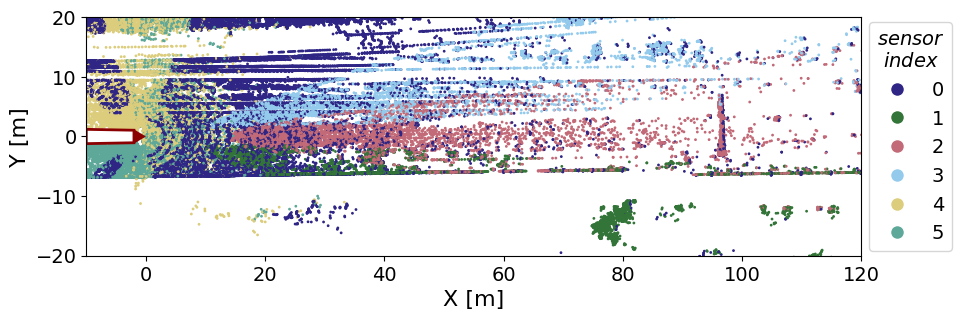

In [60]:
df = df.sample(frac=1) #df.sort_values(by="sensor_id", ascending=True)

color_map={0:[46,37,133],    # https://www.nceas.ucsb.edu/sites/default/files/2022-06/Colorblind%20Safe%20Color%20Schemes.pdf
           1:[51,117,56],
           2:[194,106,119],
           3:[148,203,236],
           4:[220,205,125],
           5:[93,168,153]}

# Create 2D plot with sensor showing in point cloud 
# Extract data for the first plot
x1 = df["X"]
y1 = df["Y"]
c1 = [np.array(color_map[segmentation]) / 255 for segmentation in df["sensor_id"]]
#c1 = df["sensor_id"]/255 #[np.array(color_map[segmentation]) / 255 for segmentation in original_dict["segment"]]

# Create a figure with two subplots (one on top of the other)
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 7))

# Plot the first set of data on the first axis
scatter1 = ax1.scatter(x1, y1, c=c1, s=1)
ax1.set_xlim(-10, 120)
ax1.set_ylim(-20, 20)
ax1.set_aspect('equal')
#ax1.set_title("Point cloud colored by $\it{sensor \, \, index}$", fontsize=16)
ax1.set_xlabel('X [m]', fontsize=16)
ax1.set_ylabel('Y [m]', fontsize=16)

ax1.tick_params(axis='both', which='major', labelsize=14)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color_map[0]) / 255, markersize=10, label='0'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color_map[1]) / 255, markersize=10, label='1'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color_map[2]) / 255, markersize=10, label='2'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color_map[3]) / 255, markersize=10, label='3'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color_map[4]) / 255, markersize=10, label='4'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color_map[5]) / 255, markersize=10, label='5'),
]

# Add the legend to the first subplot in the upper left corner
ax1.legend(handles=legend_elements, loc='center right', title_fontsize= 14, fontsize=14,title="$\it{sensor}$\n $\it{index}$", bbox_to_anchor=(1.13, 0.5))

# Add shape
rectangle_point =np.array([[-2,-1.05],[-2,1.05],[-10,1.2],[-10,-1.2]])
locomotive = plt.Polygon(rectangle_point, facecolor="white", edgecolor="darkred",lw=2)
plt.gca().add_patch(locomotive)

triangle_point =np.array([[-2,-1.2],[-2,1.2],[0,0]])
t1 = plt.Polygon(triangle_point, color="darkred",lw=0)
plt.gca().add_patch(t1)

fig.savefig("/workspaces/baseline/exp/figures/report_figs/pcd_by_sensor_index.jpeg", dpi=400,bbox_inches="tight")

Generating the recall map over here FOR VAL SET: 

In [39]:
recall_map_baseline = np.load("/workspaces/baseline/exp/data_for_plot_creation/recall_map_track_baseline.npy")
recall_map_best_weight = np.load("/workspaces/baseline/exp/data_for_plot_creation/recall_map_track_best_sparse_augment.npy")
GT_map_baseline = np.load("/workspaces/baseline/exp/data_for_plot_creation/GT_map_track_baseline.npy")
GT_map_best_weight = np.load("/workspaces/baseline/exp/data_for_plot_creation/GT_map_track_best_sparse_augment.npy")
recall_map_baseline_Paste_augm_0_0 = np.load("/workspaces/baseline/exp/VAL_SET_inference_prob_online_paste_0.0/recall_map_track.npy")

In [40]:
diff_map = recall_map_best_weight-recall_map_baseline

In [41]:
def create_fig_error_map(map, color_map_title, vmin=0,vmax=1,cmap=None):
    plt.figure(figsize=(17,5))
    title = f"Number of misclassified points from GT class Track \ndivided by number of GT points for that class, per grid cell of 1x1 m \n(Computed on entire validation set)"

    # This will do the "alt" plot version i
    ax = sns.heatmap(map, linewidth=0.,square=True, vmin=vmin,vmax=vmax,cmap=cmap)#,norm=LogNorm()) # Transpose so that x values are represented horizontaly, on the x axis. Uncomment last arugment to put in log norm
    #The two line below will do the original version style which was in the powerpoint for pres. 2
    # error_map[error_map==np.NaN] = 0
    # ax = sns.heatmap(error_map, linewidth=0.,square=True, vmax=1)

    ax.figure.axes[-1].set_ylabel(color_map_title, size=16)


    # ax.axhline(y = 0, color='k',linewidth = 1)  # add frame around heatmap
    # ax.axhline(y = 39.99, color = 'k', linewidth = 1) 
    # ax.axvline(x = 0, color = 'k',linewidth = 1) 
    # ax.axvline(x = 129.99,  color = 'k', linewidth = 1)  

    #ax.set_title(title, fontdict = {'fontsize': 16}, pad=60) #.set_title('Title', pad=20)
    cax = ax.figure.axes[-1] # Change size of ticks in colorbar for heatmap
    cax.tick_params(labelsize=14)
    plt.xlabel("X [m]",fontsize=16)
    plt.ylabel("Y [m]",fontsize=16)
    plt.xticks(np.arange(0,131,10), np.arange(-10,121,10),fontsize=14)
    plt.yticks(np.arange(0,41,10), np.arange(20,-21,-10),fontsize=14) # The y axis is inverted in the heatmp xompared to what we expect

    # Add shape
    #rectangle_point =np.array([[-2,-1.05],[-2,1.05],[-10,1.2],[-10,-1.2]])
    rectangle_point =np.array([[8,18.95],[8,21.05],[0,21.2],[0,18.8]])
    #rectangle_point =np.array([[0,0],[10,10],[0,10],[10,0]])
    locomotive = plt.Polygon(rectangle_point, facecolor="white", edgecolor="darkred",lw=2)
    ax.add_patch(locomotive)

    triangle_point =np.array([[8,18.8],[8,21.2],[10,20]])
    t1 = plt.Polygon(triangle_point, color="darkred",lw=0)
    ax.add_patch(t1)

    return ax.figure
    # plt.savefig(export_path,bbox_inches='tight')
    # plt.clf() # Clear figure for next creation
    # plt.close('all')



/tmp/ipykernel_575/3511432093.py:2: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



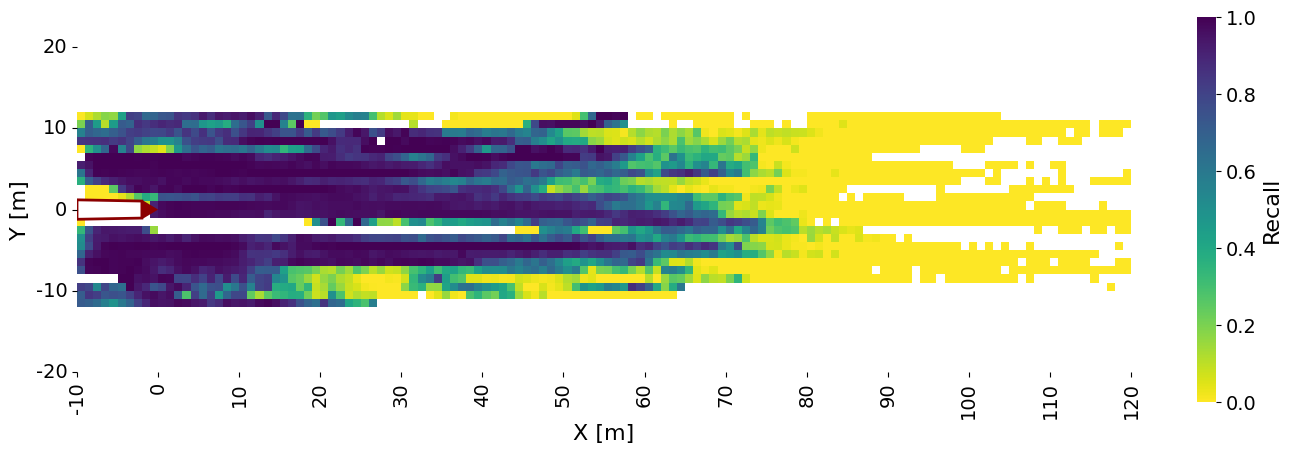

In [42]:
fig = create_fig_error_map(recall_map_baseline, "Recall", cmap="viridis_r")
fig.show()
# fig.savefig("/workspaces/baseline/exp/figures/report_figs/recall_maps/VAL_SET_recall_map_22_05_24.png" ,bbox_inches='tight',dpi=300)

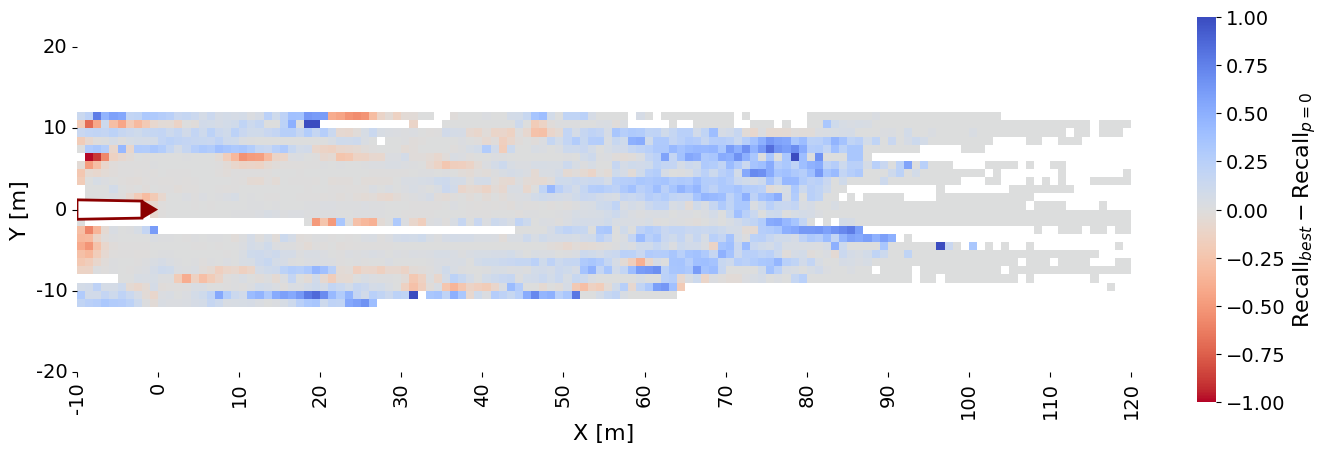

In [43]:
fig = create_fig_error_map(diff_map, "$\mathrm{Recall}_{best}-\mathrm{Recall}_{p=0}$",vmin=-1,cmap="coolwarm_r")
plt.savefig("/workspaces/baseline/exp/figures/report_figs/diff_recall_map_VAL_SET_22_05_24.png" ,bbox_inches='tight')

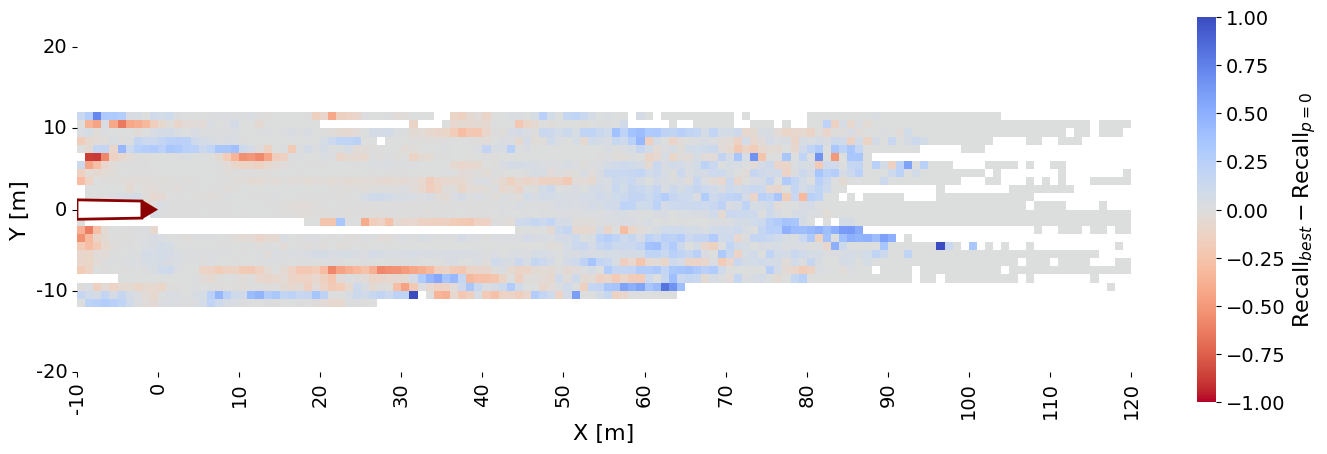

In [8]:
# With the weight from experiment 13_08_24
diff_map_Paste_augm_0_0 = recall_map_best_weight-recall_map_baseline_Paste_augm_0_0
fig = create_fig_error_map(diff_map_Paste_augm_0_0, "$\mathrm{Recall}_{best}-\mathrm{Recall}_{p=0}$",vmin=-1,cmap="coolwarm_r")
plt.savefig("/workspaces/baseline/exp/figures/report_figs/diff_recall_map_VAL_SET_13_08_24.png" ,bbox_inches='tight')

#### Results with the Test set

In [44]:
test_set_Recall_map_best = np.load("/workspaces/baseline/exp/final_TEST_weight_psparse09_40-50m/recall_map_track.npy")
test_set_Recall_map_baseline = np.load("/workspaces/baseline/exp/final_TEST_baseline_run_normalizedFalse/recall_map_track.npy")

GT_map_baseline_test_set = np.load("/workspaces/baseline/exp/final_TEST_baseline_run_normalizedFalse/GT_map_track.npy")
GT_map_best_weight_test_set = np.load("/workspaces/baseline/exp/final_TEST_weight_psparse09_40-50m/GT_map_track.npy")

# Values with the new test with wieght coming from paste augment 0.0 prob
test_set_Recall_map_baseline_OnlinePaste_00 = np.load("/workspaces/baseline/exp/final_TEST_baseline_run_13_08_24/recall_map_track.npy")

In [45]:
np.all(GT_map_baseline_test_set==GT_map_best_weight_test_set)

True

In [46]:
diff_map_test_set = test_set_Recall_map_best - test_set_Recall_map_baseline

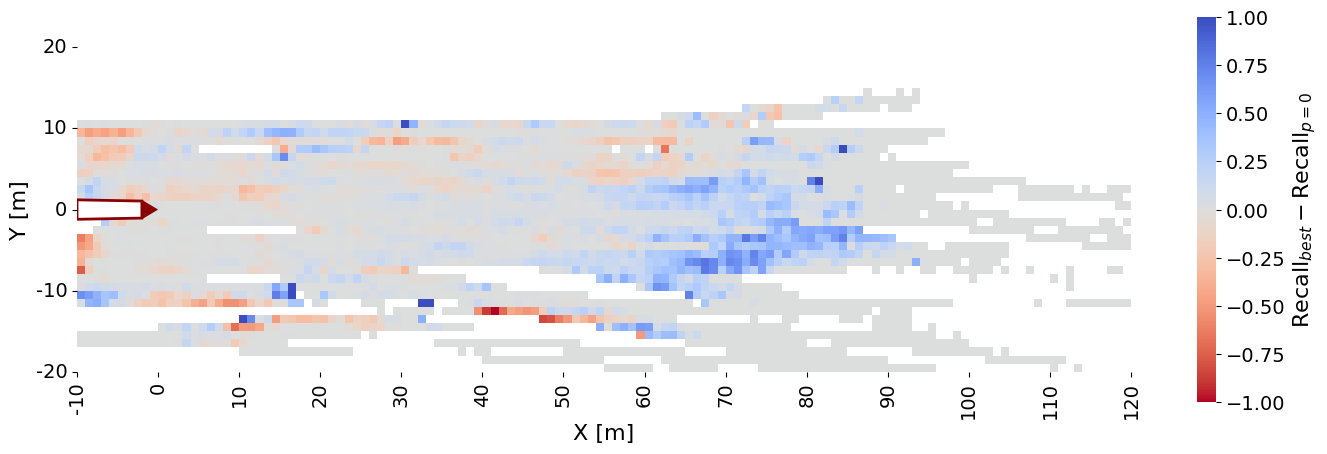

In [47]:
fig = create_fig_error_map(diff_map_test_set, "$\mathrm{Recall}_{best}-\mathrm{Recall}_{p=0}$",vmin=-1,cmap="coolwarm_r")
plt.savefig("/workspaces/baseline/exp/figures/report_figs/diff_recall_map_TEST_SET_22_05_24.png" ,bbox_inches='tight')

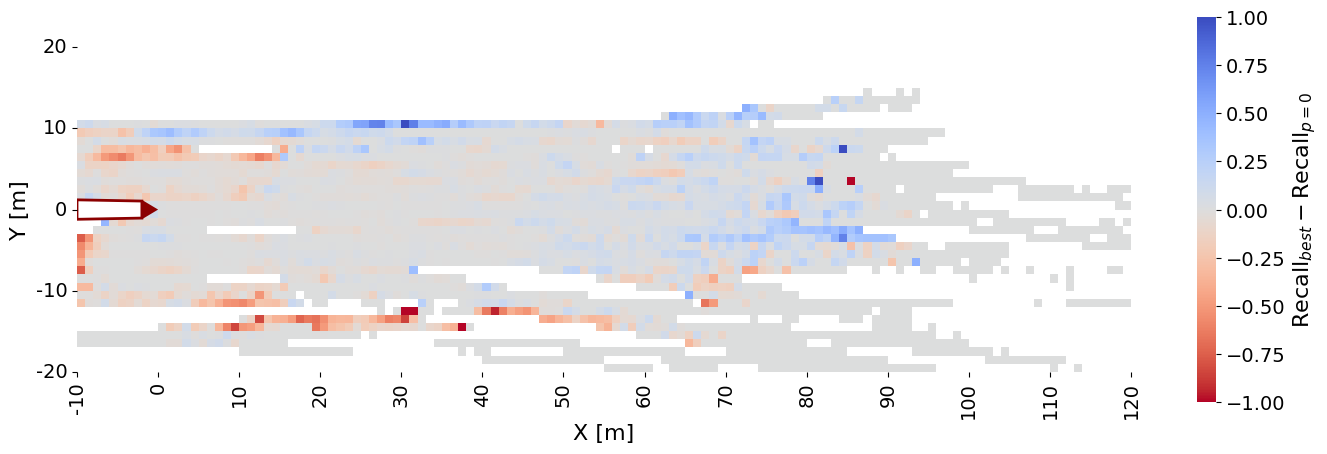

In [13]:
"""Plot with the weight resulting form the experiment Paste augment all tricks 0.0 prob"""
diff_map_test_set_OnlinePaste_00 = test_set_Recall_map_best - test_set_Recall_map_baseline_OnlinePaste_00
fig = create_fig_error_map(diff_map_test_set_OnlinePaste_00, "$\mathrm{Recall}_{best}-\mathrm{Recall}_{p=0}$",vmin=-1,cmap="coolwarm_r")
plt.savefig("/workspaces/baseline/exp/figures/report_figs/diff_recall_map_TEST_SET_13_08_24.png" ,bbox_inches='tight')

#### Bar plot comparing the baseline and best weight :

In [150]:
# df = pd.read_csv("/workspaces/baseline/exp/data_for_plot_creation/wandb_riou_testset_baseline_vs_best.csv")
df = pd.read_csv("/workspaces/baseline/exp/data_for_plot_creation/wandb_riou_testset_baseline13_08_24_vs_best.csv")

In [151]:
df

epoch  weight: online paste p=0.0 - _step  \
0      1                                  25   
1      2                                 126   
2      3                                 227   
3      4                                 328   
4      5                                 429   
5      6                                 530   

   weight: online paste p=0.0 - _step__MIN  \
0                                        5   
1                                      106   
2                                      207   
3                                      308   
4                                      409   
5                                      510   

   weight: online paste p=0.0 - _step__MAX  \
0                                       45   
1                                      146   
2                                      247   
3                                      348   
4                                      449   
5                                      550   

   weight: online paste p=0.0 - per_class/iou/0-20/track  \
0                                           0.855280       
1                                           0.855604       
2                                           0.855419       
3                                           0.855716       
4                                           0.855714       
5                                           0.855814       

   weight: online paste p=0.0 - per_class/iou/0-20/track__MIN  \
0                                           0.855280            
1                                           0.855604            
2                                           0.855419            
3                                           0.855716            
4                                           0.855714            
5                                           0.855814            

   weight: online paste p=0.0 - per_class/iou/0-20/track__MAX  \
0                                           0.855280            
1                                           0.855604            
2                                           0.855419            
3                                           0.855716            
4                                           0.855714            
5                                           0.855814            

   weight: online paste p=0.0 - per_class/iou/20-40/track  \
0                                           0.810785        
1                                           0.811187        
2                                           0.811188        
3                                           0.811156        
4                                           0.811204        
5                                           0.811279        

   weight: online paste p=0.0 - per_class/iou/20-40/track__MIN  \
0                                           0.810785             
1                                           0.811187             
2                                           0.811188             
3                                           0.811156             
4                                           0.811204             
5                                           0.811279             

   weight: online paste p=0.0 - per_class/iou/20-40/track__MAX  ...  \
0                                           0.810785            ...   
1                                           0.811187            ...   
2                                           0.811188            ...   
3                                           0.811156            ...   
4                                           0.811204            ...   
5                                           0.811279            ...   

   weight: online sparse p=0.6, r=40-50 - per_class/iou/20-40/track__MAX  \
0                                           0.810898                       
1                                           0.810916                       
2                                           0.810701                  

In [152]:
df.columns = df.columns.str.replace("weight: online paste p=0.0 -", "baseline", regex=True)
df.columns = df.columns.str.replace("weight: online sparse p=0.6, r=40-50 -", "best",regex=True)
df.columns = df.columns.str.replace("per_class/iou/", "", regex=True)
df = df.drop(columns=[col for col in df.columns if 'MIN' in col or 'MAX' in col]) # Remove the useless columns that wandb generates
df.columns = df.columns.str.replace("/track", "m", regex=True)

In [153]:
df

epoch  baseline _step  baseline 0-20m  baseline 20-40m  baseline 40-60m  \
0      1              25        0.855280         0.810785         0.619963   
1      2             126        0.855604         0.811187         0.622395   
2      3             227        0.855419         0.811188         0.623035   
3      4             328        0.855716         0.811156         0.623377   
4      5             429        0.855714         0.811204         0.623256   
5      6             530        0.855814         0.811279         0.623478   

   baseline 60-80m  baseline 80-100m  best _step  best 0-20m  best 20-40m  \
0         0.441798          0.063624          25    0.842323     0.810898   
1         0.442724          0.061968         126    0.842365     0.810916   
2         0.442553          0.062162         227    0.842445     0.810701   
3         0.442489          0.063199         328    0.842475     0.810803   
4         0.442426          0.064387         429    0.842508     0.810616   
5         0.441853          0.064848         530    0.842568     0.810538   

   best 40-60m  best 60-80m  best 80-100m  
0     0.629961     0.465255      0.114852  
1     0.630868     0.466164      0.113828  
2     0.630868     0.465388      0.114088  
3     0.631257     0.465227      0.115735  
4     0.631545     0.464721      0.114789  
5     0.632082     0.464784      0.114401

In [154]:
["0-20m", "20-40m", "40-60m", ]
x = ["0-20m", "20-40m", "40-60m", "60-80m", "80-100m"]
y_baseline = df[df["epoch"]==1][["baseline 0-20m", "baseline 20-40m", "baseline 40-60m", "baseline 60-80m", "baseline 80-100m"]]
y_best = df[df["epoch"]==1][["best 0-20m", "best 20-40m", "best 40-60m", "best 60-80m", "best 80-100m"]]


In [155]:
df_baseline = pd.DataFrame.from_dict({"Range":x,"rIoU":y_baseline.values.flatten()*100, "Run":["Baseline"]*5})
df_best = pd.DataFrame.from_dict({"Range":x,"rIoU":y_best.values.flatten()*100, "Run":["Best"]*5})
plot_df = pd.concat((df_best,df_baseline))

In [157]:
fig = px.bar(plot_df, x="Range", y="rIoU", color="Run", barmode="group")

# Update layout to adjust font sizes and legend position
fig.update_layout(
    width=800,
    height=400,
    xaxis_title_font=dict(size=16),  # Set x-axis title font size
    yaxis_title_font=dict(size=16),  # Set y-axis title font size
    legend_font=dict(size=14),       # Set legend font size
    legend=dict(yanchor="top", y=1, xanchor="right", x=1),           # Move legend to the left (adjust x as needed)
    margin={'t':0,'l':0,'b':0,'r':0}
)

# Update x and y axis ticks font size
fig.update_xaxes(tickfont=dict(size=14))  # Set x-axis tick font size
fig.update_yaxes(tickfont=dict(size=14))  # Set y-axis tick font size

# Show the plot
fig.show()
# fig.write_image("/workspaces/baseline/exp/figures/report_figs/TEST_SET_bar_plot_iou_track_compare_13_08_24.jpeg", scale=4)